In [48]:
data = data[['open', 'high', 'low', 'close', 'volume']]
data.to_csv('/Users/abnerteng/GitHub/TMBA-projects/data/BTCUSD.csv')
pd.read_csv('/Users/abnerteng/GitHub/TMBA-projects/data/BTCUSD.csv', parse_dates = True, index_col = 'startTime')

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28796.0,28836.0,28787.0,28829.5,74365.00665
2020-12-31 16:01:00+00:00,28829.5,28834.0,28728.0,28746.0,326660.45600
2020-12-31 16:02:00+00:00,28746.0,28758.5,28704.0,28708.0,162065.61150
2020-12-31 16:03:00+00:00,28708.0,28738.0,28707.5,28709.0,42449.10475
2020-12-31 16:04:00+00:00,28709.5,28752.5,28693.5,28731.5,75324.97115
...,...,...,...,...,...
2022-07-21 15:55:00+00:00,22651.0,22669.0,22650.0,22663.0,272847.80390
2022-07-21 15:56:00+00:00,22663.0,22666.0,22654.0,22658.0,87820.37250
2022-07-21 15:57:00+00:00,22658.0,22659.0,22641.0,22643.0,15790.17300


In [49]:
rule = '1D'
d1 = data.resample(rule = rule, closed = 'right', label = 'right').first()[['open']]
d2 = data.resample(rule = rule, closed = 'right', label = 'right').max()[['high']]
d3 = data.resample(rule = rule, closed = 'right', label = 'right').min()[['low']]
d4 = data.resample(rule = rule, closed = 'right', label = 'right').last()[['close']]
d5 = data.resample(rule = rule, closed = 'right', label = 'right').sum()[['volume']]

df = pd.concat([d1, d2, d3, d4, d5], axis = 1)
df.iloc[0:3]

,open,high,low,close,volume
startTime,,,,,
2021-01-01 00:00:00+00:00,28796.0,29206.5,28322.5,29014.5,4.885853e+07
2021-01-02 00:00:00+00:00,29014.5,29691.5,28700.0,29376.5,1.720617e+08
2021-01-03 00:00:00+00:00,29376.5,33349.5,29023.5,32241.0,2.544067e+08


In [50]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['5SMA'] = df['close'].rolling(window = 5, center = False).mean()

for i in range(len(df)):
    df['upper_bound'] = df['ma'] + times_of_std * df['std']
    df['lower_bound'] = df['ma'] - times_of_std * df['std']
    df['BBW'] = (df['upper_bound'] - df['lower_bound']) / df['ma']
    df['threshold'] = 0.25

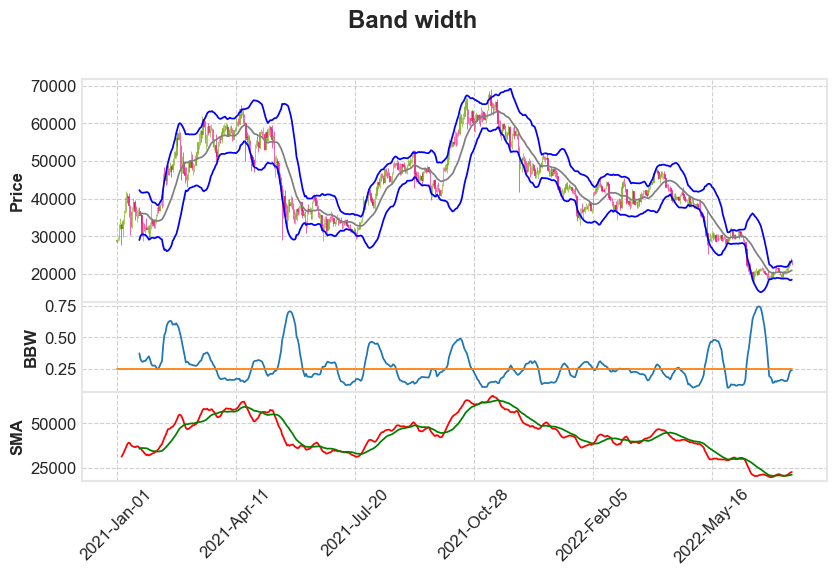

In [51]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close']]
BBand = [ mpf.make_addplot(df['lower_bound'], color = 'blue'), 
          mpf.make_addplot(df['upper_bound'], color = 'blue'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['BBW'], panel = 1, ylabel = 'BBW'),
          mpf.make_addplot(df['threshold'], panel = 1, secondary_y = False), 
          mpf.make_addplot(df['5SMA'], panel = 2, color = 'red', ylabel = 'SMA'),
          mpf.make_addplot(df['ma'], panel = 2, color = 'green', secondary_y = False)]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), title = 'Band width')

                              profit  profitfee
startTime                                      
2021-01-01 00:00:00+00:00   0.000000   0.000000
2021-01-02 00:00:00+00:00   0.000000   0.000000
2021-01-03 00:00:00+00:00   0.000000   0.000000
2021-01-04 00:00:00+00:00   0.000000   0.000000
2021-01-05 00:00:00+00:00   0.000000   0.000000
...                              ...        ...
2022-07-18 00:00:00+00:00  84.705899  82.232004
2022-07-19 00:00:00+00:00  85.763409  83.289513
2022-07-20 00:00:00+00:00  81.784806  79.310910
2022-07-21 00:00:00+00:00  79.238401  76.764505
2022-07-22 00:00:00+00:00  79.664856  76.705526

[568 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

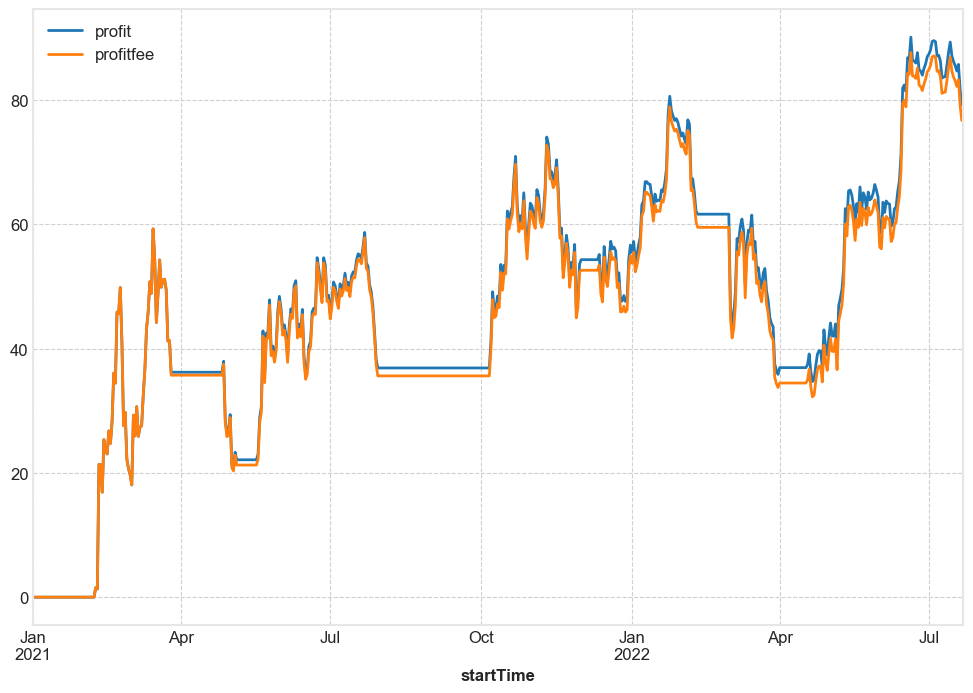

In [52]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['5SMA'][i] < df['ma'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
        
        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['5SMA'][i] > df['ma'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] < df['threshold'][i]) and df['5SMA'][i] < df['ma'][i] or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i]) and df['5SMA'][i] > df['ma'][i] or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [53]:
print((df['close'][-1] - df['close'][0]) / df['close'][0])

-0.21945923589929173


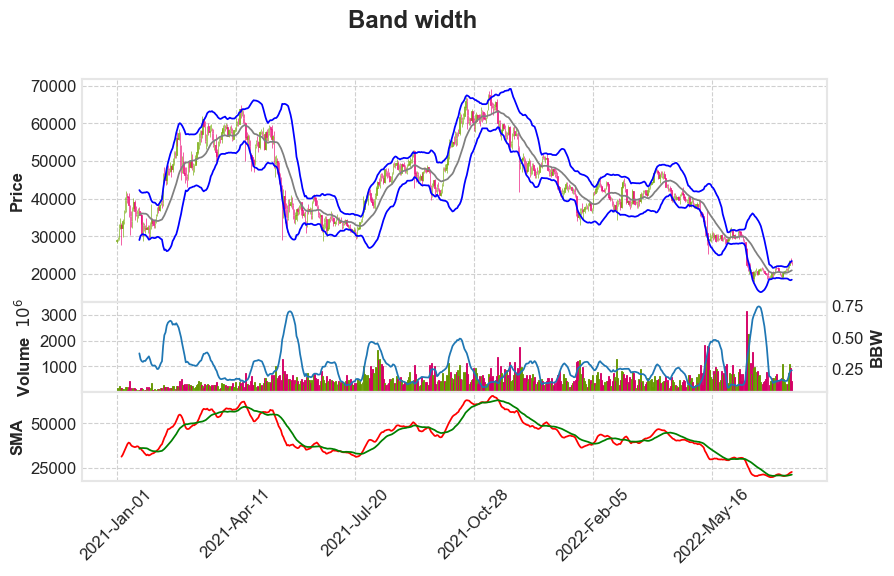

In [55]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close', 'volume']]
BBand = [ mpf.make_addplot(df['lower_bound'], color = 'blue'), 
          mpf.make_addplot(df['upper_bound'], color = 'blue'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['BBW'], panel = 1, ylabel = 'BBW'),
          mpf.make_addplot(df['threshold'], panel = 1, secondary_y = False), 
          mpf.make_addplot(df['5SMA'], panel = 2, color = 'red', ylabel = 'SMA'),
          mpf.make_addplot(df['ma'], panel = 2, color = 'green', secondary_y = False)]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), volume = True, title = 'Band width')

In [56]:
print(buy)
print(short)
print(sell)
print(buytocover)

[37, 278]
[115, 136, 344, 424, 471]
[84, 334]
[124, 210, 405, 455, 567]


In [57]:
equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

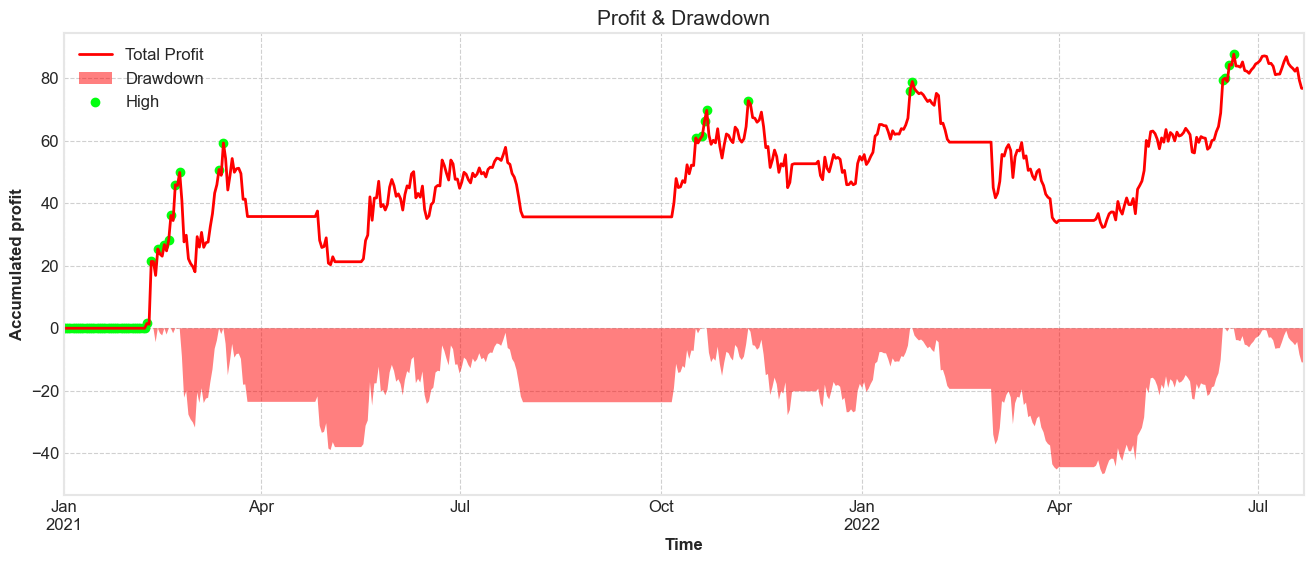

In [58]:
fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize = 15)

Text(0.5, 1.0, 'Price Movement')

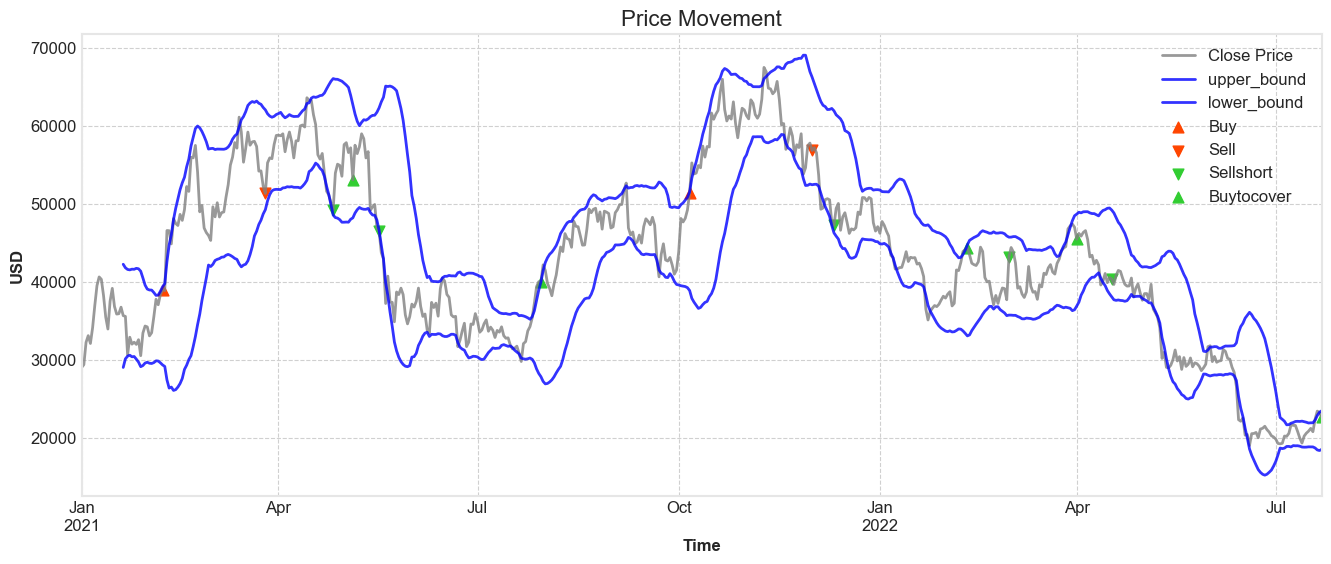

In [59]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
df['upper_bound'].plot(ax = ax, c = 'blue', grid=True, alpha=0.8)
df['lower_bound'].plot(ax = ax, c = 'blue', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[short].index, df['close'].iloc[short],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16)

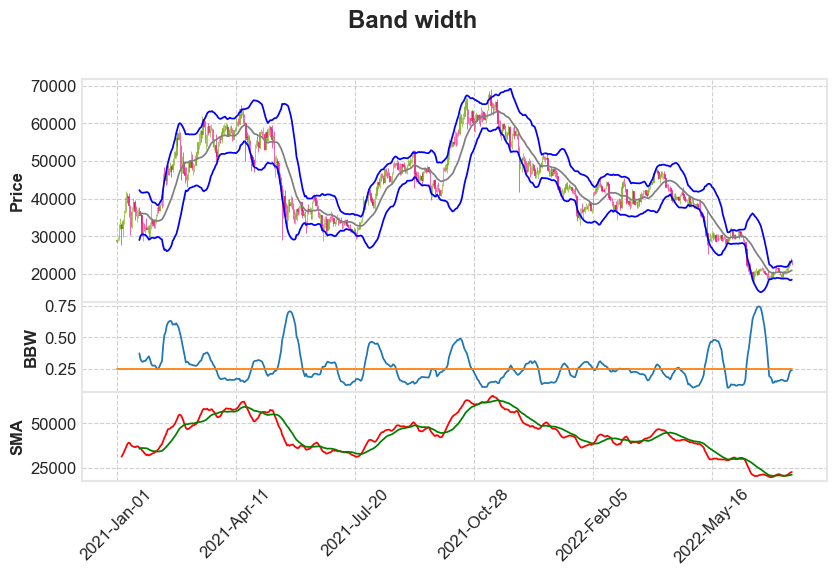

In [60]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close', 'volume']]
BBand = [ mpf.make_addplot(df['lower_bound'], color = 'blue'), 
          mpf.make_addplot(df['upper_bound'], color = 'blue'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['BBW'], panel = 1, ylabel = 'BBW'),
          mpf.make_addplot(df['threshold'], panel = 1, secondary_y = False), 
          mpf.make_addplot(df['5SMA'], panel = 2, color = 'red', ylabel = 'SMA'),
          mpf.make_addplot(df['ma'], panel = 2, color = 'green', secondary_y = False)]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), title = 'Band width')

In [61]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['5SMA'] = df['close'].rolling(window = 5, center = False).mean()
df['34SMA'] = df['close'].rolling(window = 34, center = False).mean()

for i in range(len(df)):
    df['upper_bound'] = df['ma'] + times_of_std * df['std']
    df['lower_bound'] = df['ma'] - times_of_std * df['std']
    df['BBW'] = (df['upper_bound'] - df['lower_bound']) / df['ma']
    df['threshold'] = 0.25

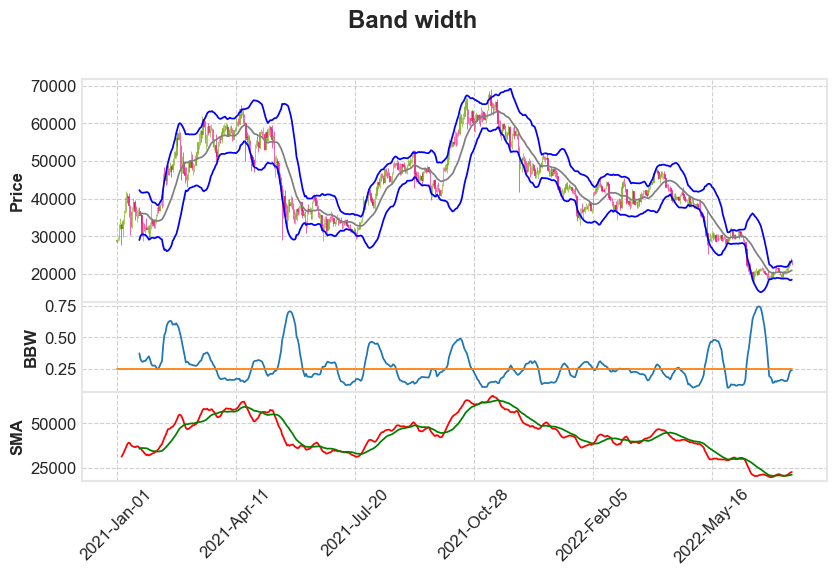

In [62]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close', 'volume']]
BBand = [ mpf.make_addplot(df['lower_bound'], color = 'blue'), 
          mpf.make_addplot(df['upper_bound'], color = 'blue'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['BBW'], panel = 1, ylabel = 'BBW'),
          mpf.make_addplot(df['threshold'], panel = 1, secondary_y = False), 
          mpf.make_addplot(df['5SMA'], panel = 2, color = 'red', ylabel = 'SMA'),
          mpf.make_addplot(df['ma'], panel = 2, color = 'green', secondary_y = False)]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), title = 'Band width')

In [63]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close', 'volume']]
BBand = [ mpf.make_addplot(df['lower_bound'], color = 'blue'), 
          mpf.make_addplot(df['upper_bound'], color = 'blue'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['BBW'], panel = 1, ylabel = 'BBW'),
          mpf.make_addplot(df['threshold'], panel = 1, secondary_y = False), 
          mpf.make_addplot(df['5SMA'], panel = 2, color = 'red', ylabel = 'SMA'),
          mpf.make_addplot(df['34MA'], panel = 2, color = 'green', secondary_y = False)]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), title = 'Band width')

KeyError: '34MA'

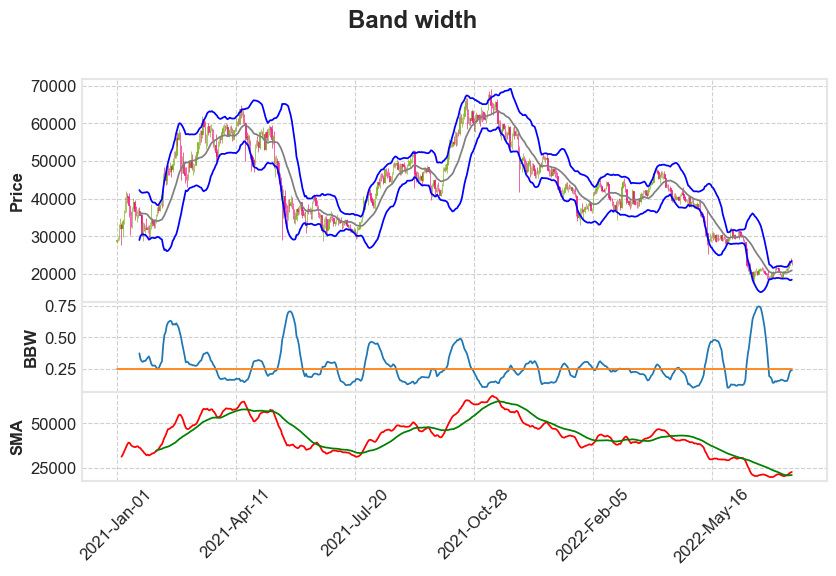

In [64]:
import mplfinance as mpf

candle_data = df[['open', 'high', 'low', 'close', 'volume']]
BBand = [ mpf.make_addplot(df['lower_bound'], color = 'blue'), 
          mpf.make_addplot(df['upper_bound'], color = 'blue'),
          mpf.make_addplot(df['ma'], color = 'gray'),
          mpf.make_addplot(df['BBW'], panel = 1, ylabel = 'BBW'),
          mpf.make_addplot(df['threshold'], panel = 1, secondary_y = False), 
          mpf.make_addplot(df['5SMA'], panel = 2, color = 'red', ylabel = 'SMA'),
          mpf.make_addplot(df['34SMA'], panel = 2, color = 'green', secondary_y = False)]
mpf.plot(candle_data, type = 'candle', style = 'binance', addplot = BBand, figratio = (18, 10), title = 'Band width')

                               profit   profitfee
startTime                                        
2021-01-01 00:00:00+00:00    0.000000    0.000000
2021-01-02 00:00:00+00:00    0.000000    0.000000
2021-01-03 00:00:00+00:00    0.000000    0.000000
2021-01-04 00:00:00+00:00    0.000000    0.000000
2021-01-05 00:00:00+00:00    0.000000    0.000000
...                               ...         ...
2022-07-18 00:00:00+00:00  112.487290  110.357832
2022-07-19 00:00:00+00:00  113.544800  111.415341
2022-07-20 00:00:00+00:00  109.566197  107.436738
2022-07-21 00:00:00+00:00  107.019792  104.890333
2022-07-22 00:00:00+00:00  107.446247  104.831354

[568 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

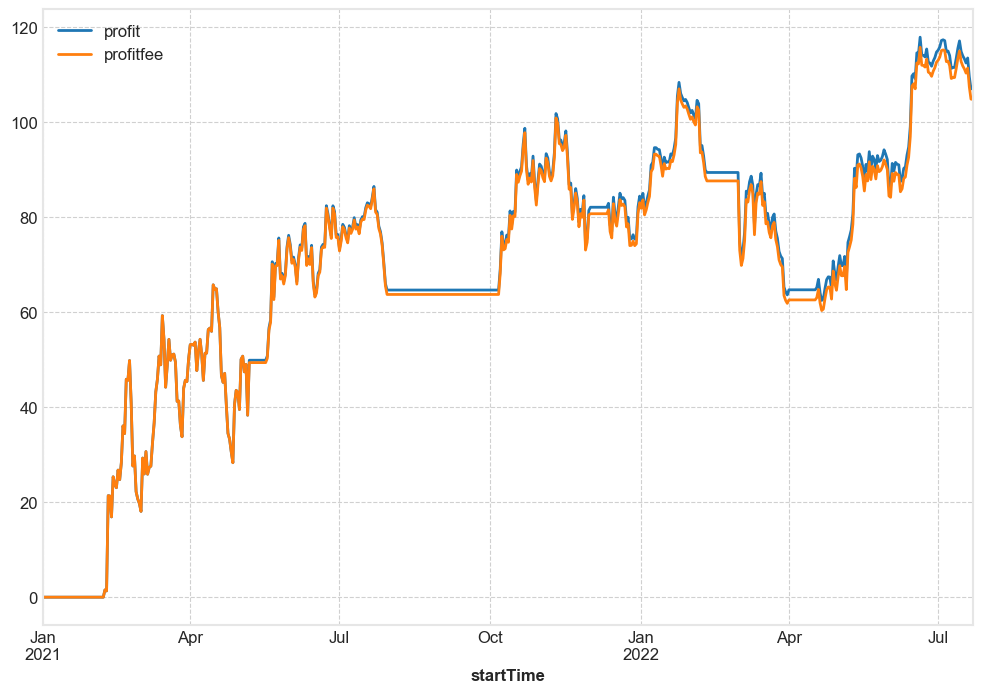

In [65]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['5SMA'][i] < df['34SMA'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
        
        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['5SMA'][i] > df['34SMA'][i]:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] < df['threshold'][i]) and df['5SMA'][i] < df['34SMA'][i] or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i]) and df['5SMA'][i] > df['34SMA'][i] or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [66]:
print(buy)
print(short)
print(sell)
print(buytocover)

[37, 278]
[136, 344, 424, 471]
[126, 334]
[210, 405, 455, 567]


In [67]:
equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

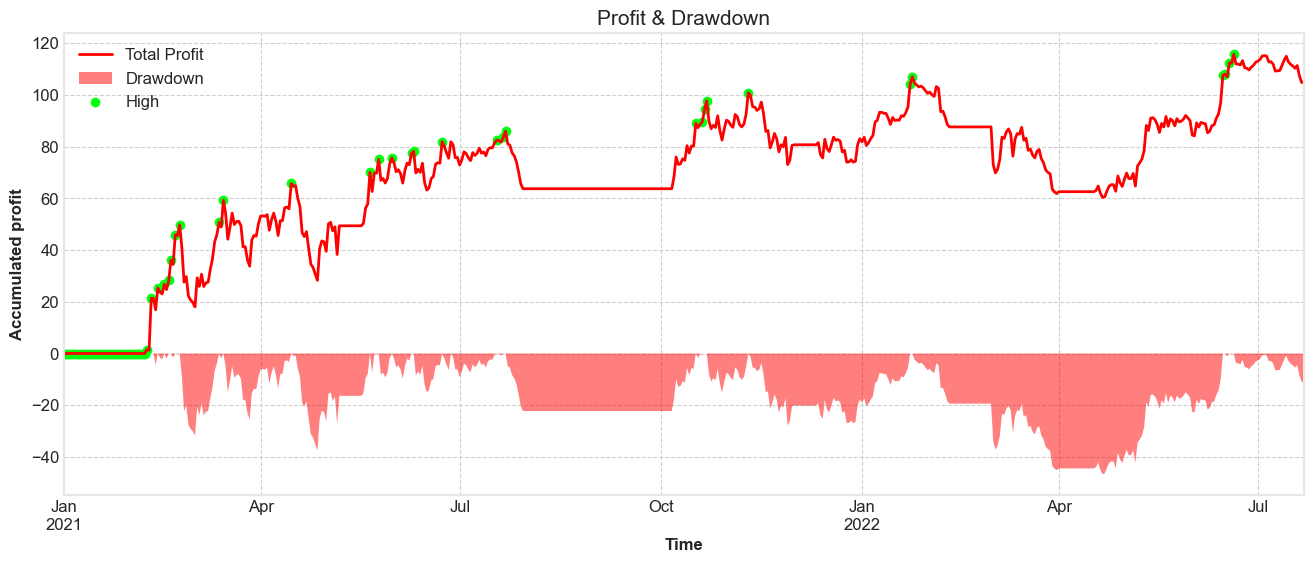

In [68]:
fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize = 15)

Text(0.5, 1.0, 'Price Movement')

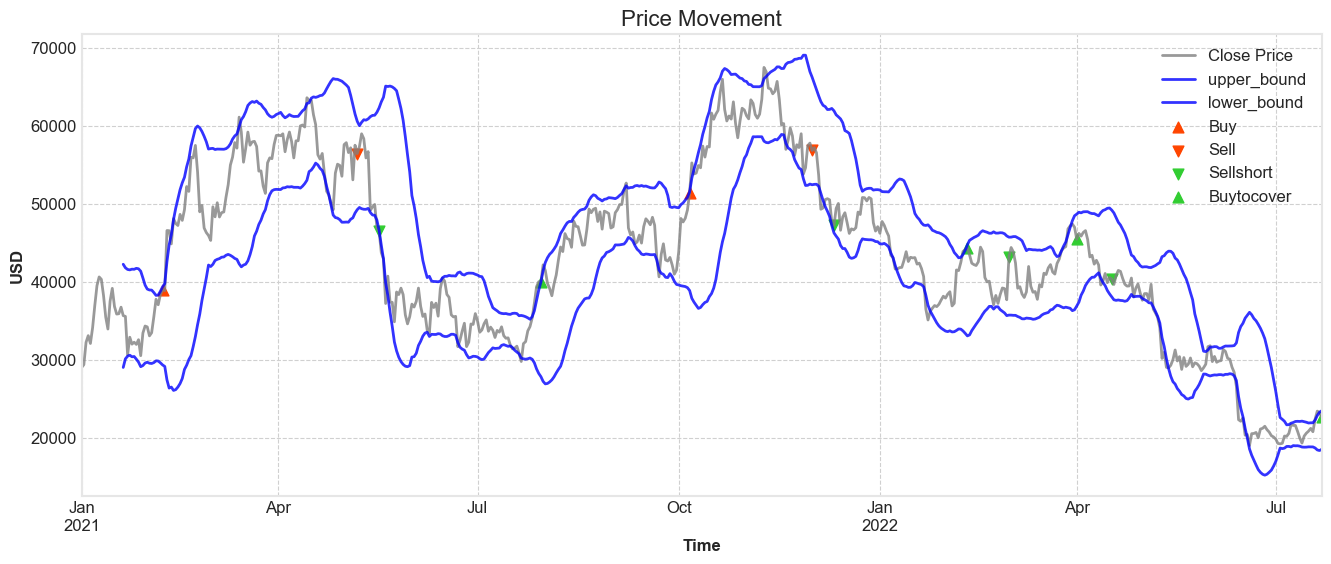

In [69]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
df['upper_bound'].plot(ax = ax, c = 'blue', grid=True, alpha=0.8)
df['lower_bound'].plot(ax = ax, c = 'blue', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[short].index, df['close'].iloc[short],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16)

In [70]:
profit = equity['profitfee'].iloc[-1]
returns = (equity['profitfee'][-1] - equity['profitfee'][37])
mdd = abs(equity['drawdown']).max()
calmarRatio = returns / mdd
tradeTimes = len(buy) + len(short)
winRate = len([i for i in profit_fee_list if i > 0]) / len(profit_fee_list)
profitFactor = sum([i for i in profit_fee_list if i > 0]) / abs(sum([i for i in profit_fee_list if i < 0]))
WLRatio = np.mean([i for i in profit_fee_list if i > 0]) / abs(np.mean([i for i in profit_fee_list if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}%')
print(f'mdd: {np.round(mdd,4)}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(WLRatio,2)}')

profit: $104.83
returns: 104.8314%
mdd: 46.6848%
calmarRatio: 2.25
tradeTimes: 6
winRate: 36.09%
profitFactor: 1.2
winLossRatio: 1.17


In [74]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['5SMA'] = df['close'].rolling(window = 5, center = False).mean()
df['34SMA'] = df['close'].rolling(window = 34, center = False).mean()

for i in range(len(df)):
    df['upper_bound'] = df['ma'] + times_of_std * df['std']
    df['lower_bound'] = df['ma'] - times_of_std * df['std']
    df['BBW'] = (df['upper_bound'] - df['lower_bound']) / df['ma']
    df['threshold'] = 0.25
    df['spread'] = df['5SMA'][i] - df['5SMA'][i-1]

In [75]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['5SMA'] = df['close'].rolling(window = 5, center = False).mean()
df['34SMA'] = df['close'].rolling(window = 34, center = False).mean()

for i in range(len(df)):
    df['upper_bound'] = df['ma'] + times_of_std * df['std']
    df['lower_bound'] = df['ma'] - times_of_std * df['std']
    df['BBW'] = (df['upper_bound'] - df['lower_bound']) / df['ma']
    df['threshold'] = 0.25
    df['spread'][i] = df['5SMA'][i] - df['5SMA'][i-1]

In [76]:
np.mean(df['spread'])

-15.414920071047955

In [77]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['5SMA'] = df['close'].rolling(window = 5, center = False).mean()
df['34SMA'] = df['close'].rolling(window = 34, center = False).mean()

for i in range(len(df)):
    df['upper_bound'][i] = df['ma'][i] + times_of_std * df['std'][i]
    df['lower_bound'][i] = df['ma'][i] - times_of_std * df['std'][i]
    df['BBW'][i] = (df['upper_bound'][i] - df['lower_bound'][i]) / df['ma'][i]
    df['threshold'] = 0.25
    df['spread'][i] = df['5SMA'][i] - df['5SMA'][i-1]

                               profit   profitfee
startTime                                        
2021-01-01 00:00:00+00:00    0.000000    0.000000
2021-01-02 00:00:00+00:00    0.000000    0.000000
2021-01-03 00:00:00+00:00    0.000000    0.000000
2021-01-04 00:00:00+00:00    0.000000    0.000000
2021-01-05 00:00:00+00:00    0.000000    0.000000
...                               ...         ...
2022-07-18 00:00:00+00:00  106.365027  100.552297
2022-07-19 00:00:00+00:00  106.365027  100.552297
2022-07-20 00:00:00+00:00  106.365027  100.552297
2022-07-21 00:00:00+00:00  106.365027  100.552297
2022-07-22 00:00:00+00:00  106.365027  100.552297

[568 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

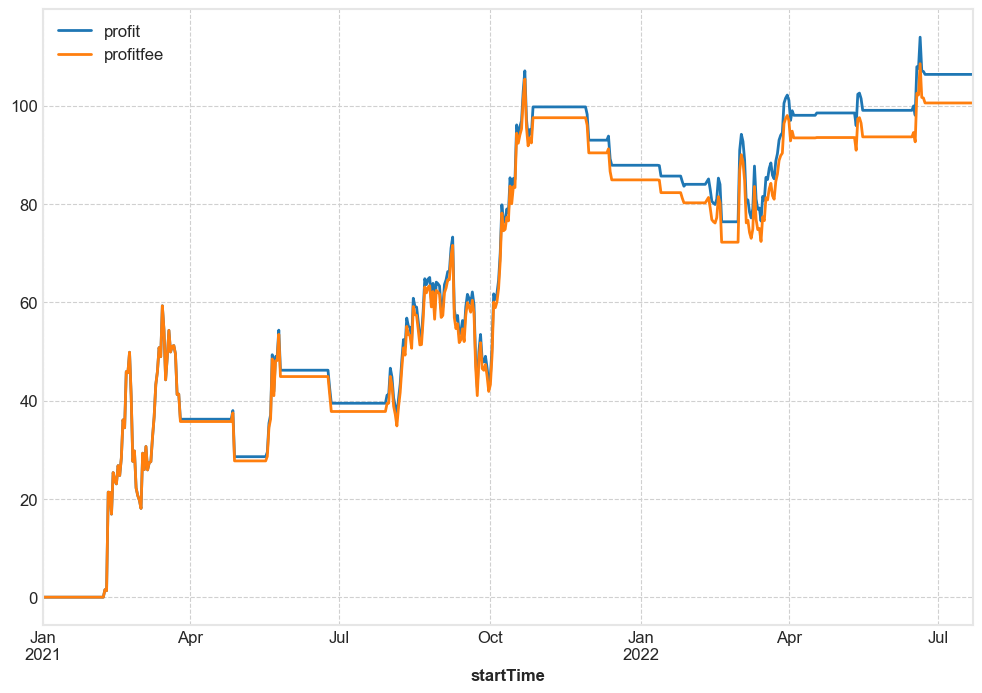

In [81]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['spread'][i] < -200:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
        
        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['spread'][i] > -200:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] < df['threshold'][i]) and df['spread'][i] < -200 or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i]) and (df['spread'][i] > -200) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

                               profit   profitfee
startTime                                        
2021-01-01 00:00:00+00:00    0.000000    0.000000
2021-01-02 00:00:00+00:00    0.000000    0.000000
2021-01-03 00:00:00+00:00    0.000000    0.000000
2021-01-04 00:00:00+00:00    0.000000    0.000000
2021-01-05 00:00:00+00:00    0.000000    0.000000
...                               ...         ...
2022-07-18 00:00:00+00:00  106.365027  100.552297
2022-07-19 00:00:00+00:00  106.365027  100.552297
2022-07-20 00:00:00+00:00  106.365027  100.552297
2022-07-21 00:00:00+00:00  106.365027  100.552297
2022-07-22 00:00:00+00:00  106.365027  100.552297

[568 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

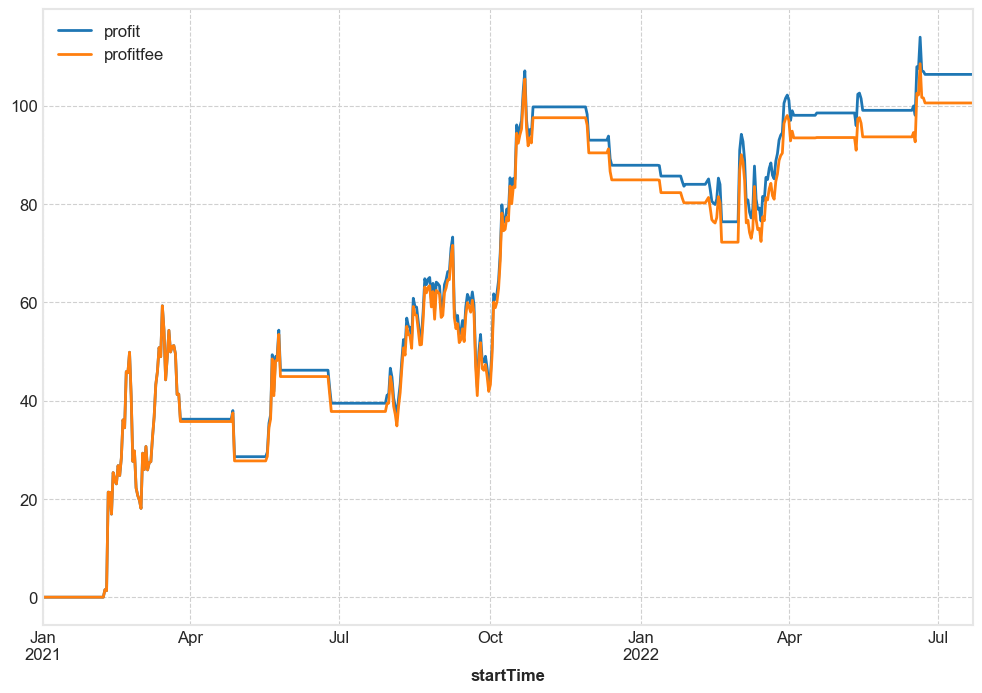

In [83]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['spread'][i] < -180:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
        
        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['spread'][i] > -180:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] < df['threshold'][i]) and df['spread'][i] < -180 or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i]) and (df['spread'][i] > -180) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [84]:
print(buy)
print(short)
print(sell)
print(buytocover)

[37, 209, 404, 424]
[115, 136, 174, 331, 344, 375, 389, 471, 495, 530]
[84, 299, 414, 458]
[117, 145, 176, 333, 347, 377, 392, 472, 500, 538]


In [85]:
equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

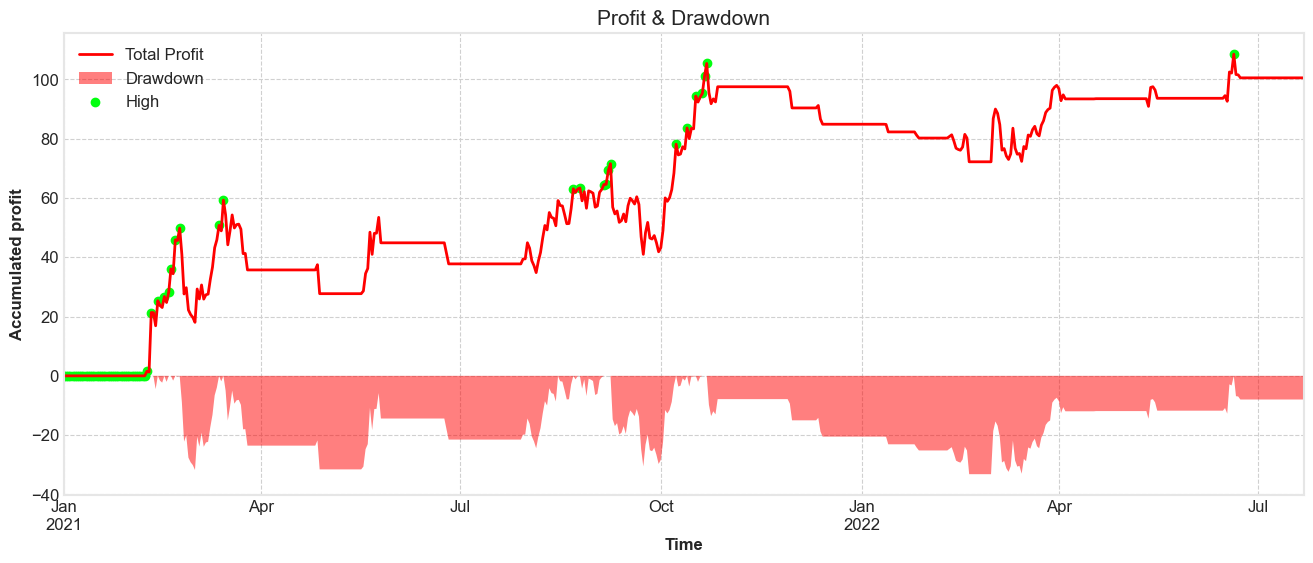

In [86]:
fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize = 15)

In [87]:
profit = equity['profitfee'].iloc[-1]
returns = (equity['profitfee'][-1] - equity['profitfee'][37])
mdd = abs(equity['drawdown']).max()
calmarRatio = returns / mdd
tradeTimes = len(buy) + len(short)
winRate = len([i for i in profit_fee_list if i > 0]) / len(profit_fee_list)
profitFactor = sum([i for i in profit_fee_list if i > 0]) / abs(sum([i for i in profit_fee_list if i < 0]))
WLRatio = np.mean([i for i in profit_fee_list if i > 0]) / abs(np.mean([i for i in profit_fee_list if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}%')
print(f'mdd: {np.round(mdd,4)}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(WLRatio,2)}')

profit: $100.55
returns: 100.5523%
mdd: 33.1812%
calmarRatio: 3.03
tradeTimes: 14
winRate: 19.72%
profitFactor: 1.3
winLossRatio: 1.23


                               profit   profitfee
startTime                                        
2021-01-01 00:00:00+00:00    0.000000    0.000000
2021-01-02 00:00:00+00:00    0.000000    0.000000
2021-01-03 00:00:00+00:00    0.000000    0.000000
2021-01-04 00:00:00+00:00    0.000000    0.000000
2021-01-05 00:00:00+00:00    0.000000    0.000000
...                               ...         ...
2022-07-18 00:00:00+00:00  106.365027  100.552297
2022-07-19 00:00:00+00:00  106.365027  100.552297
2022-07-20 00:00:00+00:00  106.365027  100.552297
2022-07-21 00:00:00+00:00  106.365027  100.552297
2022-07-22 00:00:00+00:00  106.365027  100.552297

[568 rows x 2 columns]


<AxesSubplot:xlabel='startTime'>

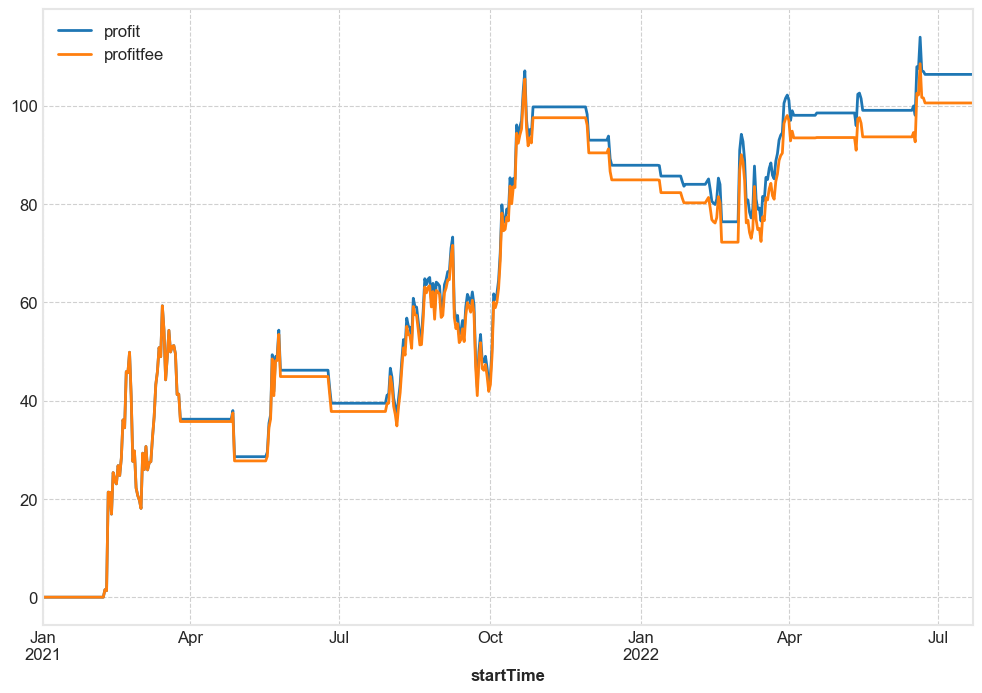

In [88]:
B_or_S = None
buy = []
sell = []
short = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]

for i in range(len(df)):

    if i == len(df) - 1:
        break

    if B_or_S == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['spread'][i] < -165:
            executeSize = money / df['open'][i+1]
            B_or_S = 'S'
            t = i + 1
            short.append(t)
        
        if df['BBW'][i-1] < df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i] and df['spread'][i] > -165:
            executeSize = money / df['open'][i+1]
            B_or_S = 'B'
            t = i + 1
            buy.append(t)

    elif B_or_S == 'B':
        profit = executeSize * (df['open'][i+1] - df['open'][i])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] < df['threshold'][i]) and df['spread'][i] < -165 or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][i+1] - df['open'][t])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif B_or_S == 'S':
        profit = executeSize * (df['open'][i] - df['open'][i+1])
        profit_list.append(profit)

        if (df['BBW'][i-1] >= df['threshold'][i-1] and df['BBW'][i] > df['threshold'][i]) and (df['spread'][i] > -165) or (i == len(df) - 2):
            pl_round = executeSize * (df['open'][t] - df['open'][i+1])
            profit_fee = profit - money * feeRate - (money + pl_round) * feeRate
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            B_or_S = None
        
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit': np.cumsum(profit_list), 'profitfee': np.cumsum(profit_fee_list)}, index = df.index)
print(equity)
equity.plot(grid = True, figsize = (12, 8))

In [89]:
print(buy)
print(short)
print(sell)
print(buytocover)

[37, 209, 404, 424]
[115, 136, 174, 331, 344, 375, 389, 471, 495, 530]
[84, 299, 414, 458]
[117, 145, 176, 333, 347, 377, 392, 472, 500, 538]


In [90]:
equity['drawdown_percent'] = (equity['profitfee'] / equity['profitfee'].cummax()) - 1
equity['drawdown'] = equity['profitfee'] - equity['profitfee'].cummax()

Text(0.5, 1.0, 'Profit & Drawdown')

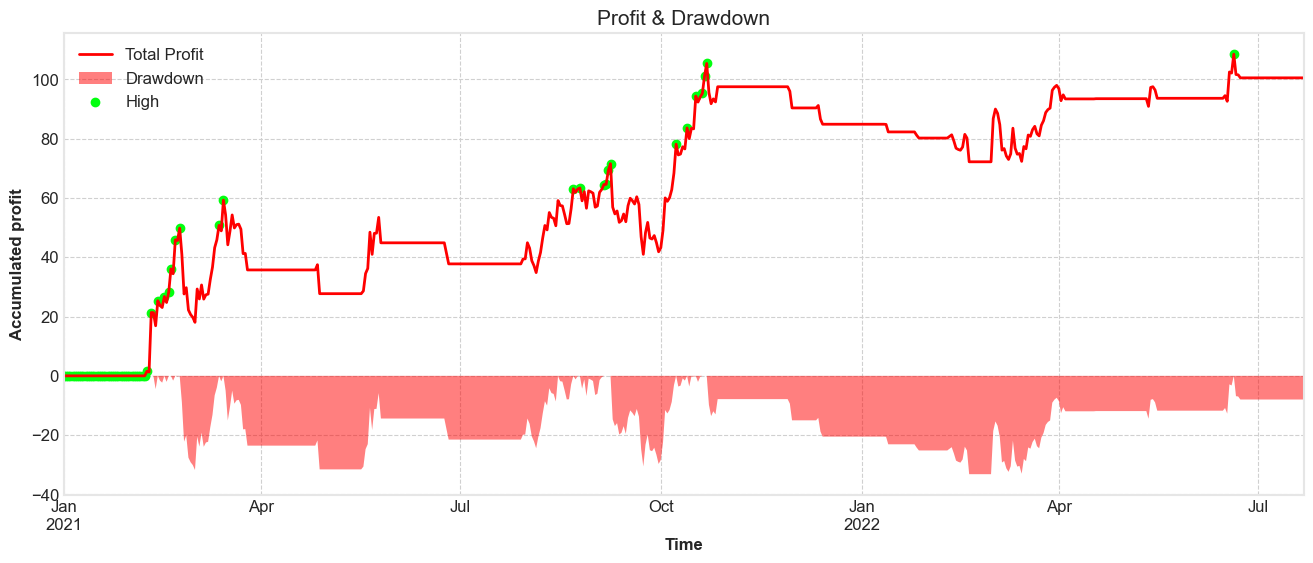

In [91]:
fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize = 15)

Text(0.5, 1.0, 'Price Movement')

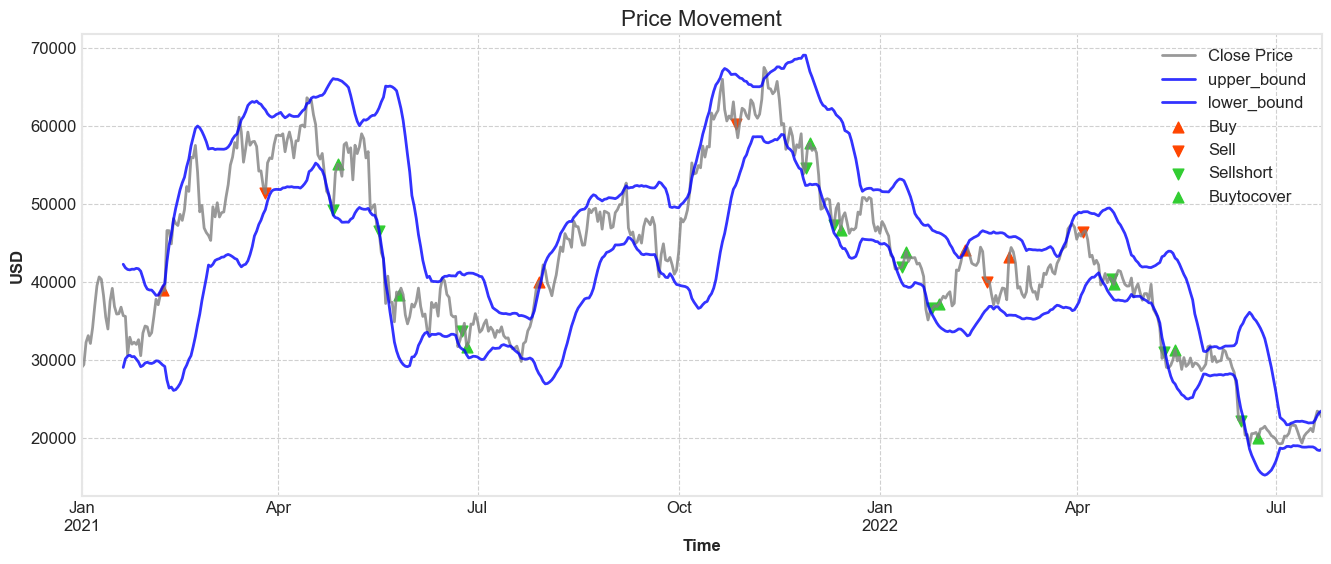

In [92]:
fig, ax = plt.subplots(figsize = (16,6))

df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
df['upper_bound'].plot(ax = ax, c = 'blue', grid=True, alpha=0.8)
df['lower_bound'].plot(ax = ax, c = 'blue', grid=True, alpha=0.8)
plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(df['close'].iloc[short].index, df['close'].iloc[short],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('USD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16)

In [93]:
profit = equity['profitfee'].iloc[-1]
returns = (equity['profitfee'][-1] - equity['profitfee'][37])
mdd = abs(equity['drawdown']).max()
calmarRatio = returns / mdd
tradeTimes = len(buy) + len(short)
winRate = len([i for i in profit_fee_list if i > 0]) / len(profit_fee_list)
profitFactor = sum([i for i in profit_fee_list if i > 0]) / abs(sum([i for i in profit_fee_list if i < 0]))
WLRatio = np.mean([i for i in profit_fee_list if i > 0]) / abs(np.mean([i for i in profit_fee_list if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'returns: {np.round(returns,4)}%')
print(f'mdd: {np.round(mdd,4)}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(WLRatio,2)}')

profit: $100.55
returns: 100.5523%
mdd: 33.1812%
calmarRatio: 3.03
tradeTimes: 14
winRate: 19.72%
profitFactor: 1.3
winLossRatio: 1.23


In [96]:
winRate2 = len([i for i in profit_fee_list if i > 0]) / (len(profit_fee_list) - len([i for i in profit_fee_list if i == 0]))
print(winRate2)

0.5137614678899083


In [97]:
fund = 100
money = 100
feeRate = 0.002
length = 20
times_of_std = 2
df['ma'] = df['close'].rolling(window = length, center = False).mean()
df['std'] = df['close'].rolling(window = length, center = False).std()
df['5SMA'] = df['close'].rolling(window = 5, center = False).mean()
df['34SMA'] = df['close'].rolling(window = 34, center = False).mean()

for i in range(len(df)):
    df['upper_bound'][i] = df['ma'][i] + times_of_std * df['std'][i]
    df['lower_bound'][i] = df['ma'][i] - times_of_std * df['std'][i]
    df['BBW'][i] = (df['upper_bound'][i] - df['lower_bound'][i]) / df['ma'][i]
    df['threshold'] = 0.25
    df['spread'][i] = df['5SMA'][i] - df['5SMA'][i-1]